# Data Understanding

## Settings

In [45]:
########################################################################################################################
# Imports & Settings
########################################################################################################################

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import time
import pycountry

In [46]:
# allow display of all rows (with scrollbar)
pd.set_option("display.max_rows", 10) #pd.set_option("display.max_rows", None)

# determine whether to use calculated language flags or recompute them
recompute_lg_flg = False

In [47]:
########################################################################################################################
# Global Variables
########################################################################################################################

# change working dir to access tempData folder
if os.getcwd().endswith('Data Understanding'):
    os.chdir('..')
    print(f'went one level up --> current workdir: {os.getcwd()}')

# source data file paths
transactions_path = 'tempData/sourceData/transactions.csv'
evaluation_path = 'tempData/sourceData/evaluation.csv'
items_path = 'tempData/sourceData/items.csv'
subject_cats_0_path = 'tempData/sourceData/subject_cats_0.csv'

# pre-processed data file paths (incl. language flags)
items_path_pp = 'tempData/processedData/items_pp.csv'

# seaborn color palette
palette_blue = "Blues_d"
dark_blue = "#011f4b"
middle_blue = "#005b96"
light_blue = "#b3cde0"

In [48]:
########################################################################################################################
# Functions
########################################################################################################################

def clean_alt_list(list_):
    list_ = list_.replace(', ', ',')
    list_ = list_.replace(',', ',')
    list_ = list_.replace('[', '')
    list_ = list_.replace(']', '')
    return list_

## Data load & initial pre-processing

In [49]:
########################################################################################################################
# Load Data & Print first summary statistics
########################################################################################################################

# Load the dmc source data
# - clicks/baskets/order over a period of 3M
# - rows: one transaction for single item
transactions_df = pd.read_csv(transactions_path, delimiter='|', sep='.', encoding='utf-8')
# - list of product ids (subset of products from items_df) to be used for prediction
evaluation_df = pd.read_csv(evaluation_path, sep='.', encoding='utf-8')
items_df = pd.read_csv(items_path, delimiter='|', sep='.', encoding='utf-8')

# load category lookup table (manually created)
subject_cats_0 = pd.read_csv(subject_cats_0_path, delimiter=';', encoding='utf-8')

# Load pre-processed df (incl. language flags)
items_df_pp = pd.read_csv(items_path_pp, delimiter=',', encoding='utf-8')

# Print description of dfs

# Get shape of dfs
print(f'shape transactions_df: {transactions_df.shape}')
#print(f'shape evaluation_df: {evaluation_df.shape}')
print(f'shape items_df: {items_df.shape}\n')

# Get col names + datatype
print(f'cols transactions_df: \n{transactions_df.dtypes}\n')
#print(f'cols evaluation_df: \n{evaluation_df.dtypes}\n')
print(f'cols items_df: \n{items_df.dtypes}\n')

# Get description of dfs
print(f'desc transactions_df: \n{transactions_df.describe()}\n')
#print(f'desc evaluation_df: \n{evaluation_df.describe()}\n')
print(f'desc items_df: \n{items_df.describe()}\n')

# Get cnt of unique sessions / items
print(f'cnt unqiue sessions: {transactions_df["sessionID"].nunique()}') #271,983
print(f'cnt unqiue items: {transactions_df["itemID"].nunique()}') #24,909

shape transactions_df: (365143, 5)
shape items_df: (78030, 6)

cols transactions_df: 
sessionID    int64
itemID       int64
click        int64
basket       int64
order        int64
dtype: object

cols items_df: 
itemID         int64
title         object
author        object
publisher     object
main topic    object
subtopics     object
dtype: object

desc transactions_df: 
           sessionID         itemID          click         basket  \
count  365143.000000  365143.000000  365143.000000  365143.000000   
mean   139586.939175   40051.292307       1.233180       0.141202   
std     80795.207871   22493.347334       1.069996       1.107574   
min         0.000000       1.000000       0.000000       0.000000   
25%     69459.500000   20713.000000       1.000000       0.000000   
50%    139608.000000   40692.000000       1.000000       0.000000   
75%    209750.500000   58916.000000       1.000000       0.000000   
max    279354.000000   79066.000000     118.000000     293.000000   

  

In [50]:
########################################################################################################################
# Preprocessing for further inspection
########################################################################################################################

# extract list of base cols 
initial_cols= list(items_df.columns)

# normalization: author col
items_df.loc[items_df['author'] == 'ohne Autor', 'author'] = None

# add col: get len of mt string
items_df['mt_len'] = items_df['main topic'].str.len()

# add col: get first element (top level category) of mt string
items_df['mt_0'] = items_df['main topic'].str[0]

# adjust subtopics: set to None if subtopics list is empty
items_df['subtopics_str'] = items_df['subtopics'].astype(str).apply(clean_alt_list)
items_df.loc[items_df['subtopics_str'].apply(len) ==0, 'subtopics_str'] = None

# add col: get click / basket / order flag
transactions_df['click_flg'] = np.where(transactions_df['click'] > 0, 1, 0)
transactions_df['basket_flg'] = np.where(transactions_df['basket'] > 0, 1, 0)
transactions_df['order_flg'] = np.where(transactions_df['order'] > 0, 1, 0)

In [51]:
# show dfs after initial pre-processing
print(f'items_df after first pre-processing:')
display(items_df.head(2))

print(f'transactions_df after first pre-processing:')
display(transactions_df.head(2))

items_df after first pre-processing:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],3.0,Y,5AH
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",3.0,A,"5AJ,AGZ,WFA,YBG,YBL,YNA,YPA"


transactions_df after first pre-processing:


,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg
0,0,21310,1,0,0,1,0,0
1,1,73018,1,0,0,1,0,0


## Overview statistics per relation / attribute

### items

#### author

# books per author:


,book_cnt,frac[%]
NaN,3240,4.152249
Garcia Santiago,1479,1.895425
"Shelley Admont, Kidkiddos Books",228,0.292195
James Manning,180,0.230681
Jules Verne,178,0.228117
Idries Shah,168,0.215302
Enid Blyton,158,0.202486
Erin Hunter,158,0.202486
R. L. Stine,138,0.176855
Terry Pratchett,115,0.147379


summary statistics of books per author:


,book_cnt,frac[%]
count,35970.000000,35970.000000
mean,2.169308,0.002780
std,19.311689,0.024749
min,1.000000,0.001282
25%,1.000000,0.001282
50%,1.000000,0.001282
75%,2.000000,0.002563
max,3240.000000,4.152249


distribution of books per author:


,book_cnt,author_cnt,author_cnt.cum,frac[%],frac.cum[%]
0,1,25849,25849,71.862663,71.862663
1,2,4858,30707,13.505699,85.368363
2,3,1855,32562,5.157075,90.525438
3,4,1043,33605,2.899639,93.425076
4,5,564,34169,1.567973,94.993050
5,6,372,34541,1.034195,96.027245
6,7,261,34802,0.725605,96.752850
7,8,187,34989,0.519878,97.272727
8,9,145,35134,0.403114,97.675841
9,10,103,35237,0.286350,97.962191


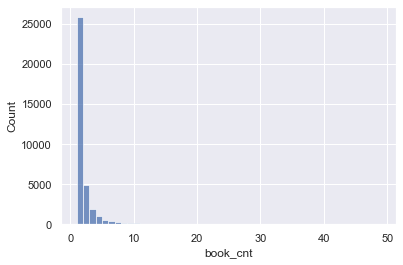

In [52]:
# count of books per author
books_per_author = pd.DataFrame.from_dict(Counter(items_df.loc[:,'author']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_author['frac[%]'] = books_per_author['book_cnt'] * 100 / books_per_author['book_cnt'].sum()

print(f'# books per author:')
display(books_per_author.head(10))

print(f'summary statistics of books per author:')
display(books_per_author.describe())

# distribution of cnt af books among authors
books_per_author_cnts = pd.DataFrame(books_per_author['book_cnt'].value_counts().reset_index()).rename(columns={'index': 'book_cnt', 
                                                                                                                'book_cnt': 'author_cnt'})
books_per_author_cnts['author_cnt.cum'] = books_per_author_cnts['author_cnt'].cumsum()
books_per_author_cnts['frac[%]'] = books_per_author_cnts['author_cnt'] * 100 / books_per_author_cnts['author_cnt'].sum()
books_per_author_cnts['frac.cum[%]'] = books_per_author_cnts['frac[%]'].cumsum()

print(f'distribution of books per author:')
display(books_per_author_cnts.head(10))
sns.set_theme()
sns.histplot(books_per_author[books_per_author['book_cnt']<50]['book_cnt'], binwidth=1)
plt.show()

#### publisher

# books per publisher:


,book_cnt,frac[%]
Books on Demand,3759,4.817378
LIGHTNING SOURCE INC,2355,3.018070
Lulu.com,1717,2.200436
Xlibris,1576,2.019736
Fichas de preescolar,1499,1.921056
iUniverse,1414,1.812124
epubli,1183,1.516084
INDEPENDENTLY PUBLISHED,1061,1.359733
AuthorHouse,1001,1.282840
Penguin Random House Children's UK,859,1.100859


summary statistics of books per publisher:


,book_cnt,frac[%]
count,7073.000000,7073.000000
mean,11.032094,0.014138
std,77.953138,0.099901
min,1.000000,0.001282
25%,1.000000,0.001282
50%,1.000000,0.001282
75%,4.000000,0.005126
max,3759.000000,4.817378


distribution of books per publisher:


,book_cnt,publisher_cnt,publisher_cnt.cum,frac[%],frac.cum[%]
0,1,3646,3646,51.548141,51.548141
1,2,1042,4688,14.732080,66.280221
2,3,514,5202,7.267072,73.547293
3,4,317,5519,4.481832,78.029125
4,5,228,5747,3.223526,81.252651
5,6,165,5912,2.332815,83.585466
6,7,115,6027,1.625901,85.211367
7,8,85,6112,1.201753,86.413120
8,9,79,6191,1.116924,87.530044
9,10,66,6257,0.933126,88.463170


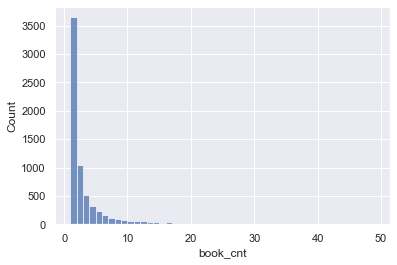

In [53]:
# count of books per publisher
books_per_publisher = pd.DataFrame.from_dict(Counter(items_df.loc[:,'publisher']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_publisher['frac[%]'] = books_per_publisher['book_cnt'] * 100 / books_per_publisher['book_cnt'].sum()

print(f'# books per publisher:')
display(books_per_publisher.head(10))

print(f'summary statistics of books per publisher:')
display(books_per_publisher.describe())

# distribution of cnt af books among publishers
books_per_publisher_cnts = pd.DataFrame(books_per_publisher['book_cnt'].value_counts().reset_index()).rename(columns={'index': 'book_cnt', 
                                                                                                                'book_cnt': 'publisher_cnt'})
books_per_publisher_cnts['publisher_cnt.cum'] = books_per_publisher_cnts['publisher_cnt'].cumsum()
books_per_publisher_cnts['frac[%]'] = books_per_publisher_cnts['publisher_cnt'] * 100 / books_per_publisher_cnts['publisher_cnt'].sum()
books_per_publisher_cnts['frac.cum[%]'] = books_per_publisher_cnts['frac[%]'].cumsum()

print(f'distribution of books per publisher:')
display(books_per_publisher_cnts.head(10))
sns.set_theme()
sns.histplot(books_per_publisher[books_per_publisher['book_cnt']<50]['book_cnt'], binwidth=1)
plt.show()

#### main topics

str len main topics:


,mt_len
count,77772.000000
mean,2.994355
std,0.746807
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,10.000000


top 5 high level cats:


,Notation,book_cnt,frac[%],Category heading
0,Y,48416,62.047930,"Children’s, Teenage and Educational"
1,F,26534,34.004870,Fiction and Related items
2,X,934,1.196976,"Graphic novels, Comic books, Cartoons"
3,W,651,0.834295,"Lifestyle, Hobbies and Leisure"
4,D,409,0.524157,"Biography, Literature and Literary studies"


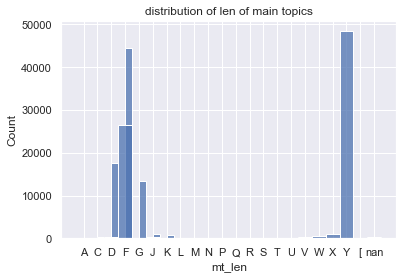

In [54]:
# get depth of main topic tree
print(f'str len main topics:')
display(pd.DataFrame(items_df["mt_len"].describe()))
mt_len_hist = sns.histplot(items_df['mt_len']).set_title(f'distribution of len of main topics')

# count of books per main topic (=mt) combo
books_per_mt = pd.DataFrame.from_dict(Counter(items_df.loc[:,'main topic']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_mt['frac[%]'] = books_per_mt['book_cnt'] * 100 / books_per_mt['book_cnt'].sum()

# plot mt_0 distribution
sns.set_theme()
sns.histplot(items_df['mt_0'].astype(str).sort_values())

# count of books per first element of mt
books_per_mt_0 = pd.DataFrame.from_dict(Counter(items_df.loc[:,'mt_0']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False).reset_index()
books_per_mt_0 = books_per_mt_0.rename(columns={'index': 'Notation'})
books_per_mt_0['frac[%]'] = books_per_mt_0['book_cnt'] * 100 / books_per_mt_0['book_cnt'].sum()

# join with category heading
books_per_mt_0 = books_per_mt_0.merge(subject_cats_0, on='Notation', how='left')
print(f'top 5 high level cats:')
display(books_per_mt_0.head(5))

### transactions

- basket: items that were added to basket but not necessarily bought
- order: items that where finally bought

In [133]:
# merge transactions with items to get title
transactions_df = transactions_df.merge(items_df[['itemID','title']], left_on='itemID', right_on='itemID', how='left')
transactions_df.head(5)

,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg,title_x,title_y
0,0,21310,1,0,0,1,0,0,Princess Poppy: The Big Mix Up,Princess Poppy: The Big Mix Up
1,1,73018,1,0,0,1,0,0,Einfach zeichnen! Step by Step,Einfach zeichnen! Step by Step
2,2,19194,1,0,0,1,0,0,Red Queen 1,Red Queen 1
3,3,40250,1,0,0,1,0,0,Meine Kindergarten-Freunde (Pirat),Meine Kindergarten-Freunde (Pirat)
4,4,46107,1,0,0,1,0,0,Mein großes Schablonen-Buch - Wilde Tiere,Mein großes Schablonen-Buch - Wilde Tiere


#### cnts per sessionID

In [142]:
# # get cnt of distinct item clicks per session
# unique_clicks_per_session = transactions_df[['sessionID', 'click_flg']].groupby('sessionID')['click_flg'].sum().reset_index().\
#     sort_values(by='click_flg', ascending=False)
# unique_clicks_per_session['frac[%]'] = unique_clicks_per_session['click_flg'] * 100 / unique_clicks_per_session['click_flg'].sum()
# unique_clicks_per_session = unique_clicks_per_session.rename(columns={'click_flg': '#clicked items unique'})

# print(f'clicked items per session:')
# display(round(unique_clicks_per_session.head(10),2))

# print(f'clicks per item summary stats:')
# display(round(unique_clicks_per_session.describe(),2))

# sns.boxplot(x=unique_clicks_per_session["#clicked items unique"])
# plt.show()

# # get cnt of distinctly ordered items per session
# orders_per_session = transactions_df[['sessionID', 'order_flg']].groupby('sessionID')['order_flg'].sum().reset_index().\
#     sort_values(by='order_flg', ascending=False).rename(columns={'order_flg': 'order_cnt'})
# orders_per_session['frac[%]'] = orders_per_session['order_cnt'] * 100 / orders_per_session['order_cnt'].sum()

# print(f'distinct orders per session (binary, w/o qty):')
# display(orders_per_session.head(10))

# print(f'distinct orders per session summary stats:')
# display(orders_per_session.describe())

# sns.boxplot(x=orders_per_session["order_cnt"])
# plt.show()

# # get cnt of distinct order sessions per item
# orders_per_item = transactions_df[['itemID', 'order_flg']].groupby('itemID')['order_flg'].sum().reset_index().\
#     sort_values(by='order_flg', ascending=False).rename(columns={'order_flg': 'order_cnt'})
# orders_per_item['frac[%]'] = orders_per_item['order_cnt'] * 100 / orders_per_item['order_cnt'].sum()

# # print(f'distinct orders per item (binary, w/o qty):')
# # display(orders_per_item.head(10))

# print(f'distinct orders per item summary stats:')
# display(orders_per_item.describe())

# get cnt of distinct orders / basket /orders per session
interaction_per_session = transactions_df[['sessionID', 
                                           'click_flg',
                                           'basket_flg',
                                           'order_flg']].groupby('sessionID').sum().reset_index()
print(f'distribution of unique items clicked, added to basket, ordered:')
display(round(interaction_per_session[['click_flg','basket_flg','order_flg']].describe(),1).loc[['count','mean','std','25%','50%','75%','max']])

# get click to basket to order conversion
items_per_basket_order = transactions_df[['itemID',
                                          'click_flg',
                                          'basket_flg',
                                          'order_flg']].groupby(['click_flg',
                                                                 'basket_flg',
                                                                 'order_flg'])['itemID'].count().reset_index().rename(columns={'itemID': 'item_cnt'})
items_per_basket_order['frac[%]'] = items_per_basket_order['item_cnt'] * 100 / items_per_basket_order['item_cnt'].sum()
print(f'click to basket to order conversion:')
display(round(items_per_basket_order.sort_values(by=['click_flg','basket_flg','order_flg'],ascending=False),2))

distribution of unique items clicked, added to basket, ordered:


,click_flg,basket_flg,order_flg
count,271983.0,271983.0,271983.0
mean,1.3,0.2,0.1
std,1.6,0.7,0.3
25%,1.0,0.0,0.0
50%,1.0,0.0,0.0
75%,1.0,0.0,0.0
max,213.0,51.0,21.0


click to basket to order conversion:


,click_flg,basket_flg,order_flg,item_cnt,frac[%]
6,1,1,1,3692,1.01
5,1,1,0,30047,8.23
4,1,0,1,80,0.02
3,1,0,0,307776,84.29
2,0,1,1,835,0.23
1,0,1,0,10414,2.85
0,0,0,1,12299,3.37


#### top interaction items

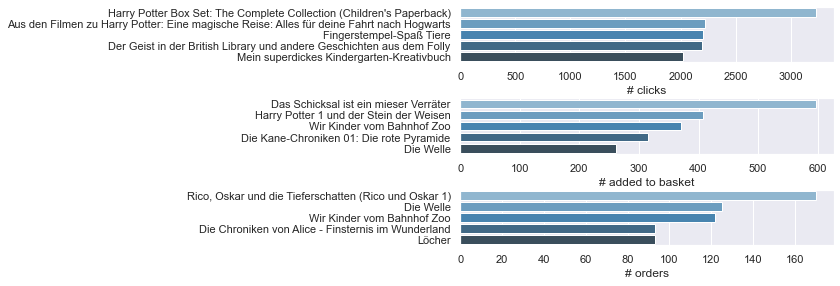

In [131]:
# get top sellers
top_interaction_items = transactions_df[['itemID', 'title',
                                         'click', 
                                         'basket', 
                                         'order']].groupby(['itemID','title']).sum().reset_index().sort_values(by='click')
top_clicked_items = top_interaction_items.sort_values(by='click',ascending=False).head(5)
top_basket_items = top_interaction_items.sort_values(by='basket',ascending=False).head(5)
top_order_items = top_interaction_items.sort_values(by='order',ascending=False).head(5)
# display(top_interaction_items.head(10))

# generate barplot
sns.set_theme()
fig, ax = plt.subplots(3,1)
plt.tight_layout()
sns.barplot(data=top_clicked_items,x='click',y='title',palette=palette_blue, ax=ax[0]).set(xlabel="# clicks",ylabel="")
sns.barplot(data=top_basket_items,x='basket',y='title',palette=palette_blue, ax=ax[1]).set(xlabel="# added to basket",ylabel="")
sns.barplot(data=top_order_items,x='order',y='title',palette=palette_blue, ax=ax[2]).set(xlabel="# orders",ylabel="")
plt.show()

# # get cnt of clicks per item
# clicks_per_item = transactions_df[['itemID', 'click']].groupby('itemID')['click'].sum().reset_index().\
#     sort_values(by='click', ascending=False).rename(columns={'click': 'click_cnt'})
# clicks_per_item['frac[%]'] = clicks_per_item['click_cnt'] * 100 / clicks_per_item['click_cnt'].sum()

# print(f'clicks per item:')
# display(clicks_per_item.head(10))

# print(f'clicks per item summary stats:')
# display(clicks_per_item.describe())

## Anomaly Detection

### Missing Values
- 9 items w/o publisher: 
    - could be anything, cannot be imputed
    - not such a crucial information to be missing
    - thus: no handling 
- 3240 items w/o author:
    - correct author might not be uniquely determinable or there might not even be a senseful author
    - thus: no handling
- 258 items w/o main topic:
    - at least subtopic is given
    - only 32 of these also have the author missing
- 36,904 items w/o subtopic:
    - in all of the cases, a main topic is given 
    - thus: still enough information available

In [154]:
# get cnt of missing values per column
missing_values = pd.DataFrame(items_df.isnull().sum()).rename(columns={0: 'cnt'})
missing_values['frac[%]'] = missing_values['cnt'] * 100 / len(items_df)
print(f'null values per column:')
display(round(missing_values.loc[initial_cols + ["subtopics_str"]],2))

# get cnt of combined null values: sum null values per row and cnt rows with #null > 1
print(f'\n# rows with null values in more than one col: {(items_df[initial_cols + ["subtopics_str"]].isnull().sum(axis=1) > 1).sum()}')
print(f'\ndistribution of null values over cols (1=null, 0=not null):')
display(pd.DataFrame((items_df[initial_cols + ['subtopics_str']].isnull() * 1).value_counts().reset_index()).rename(columns={0: '#items'}))

null values per column:


,cnt,frac[%]
itemID,0,0.00
title,0,0.00
author,3241,4.15
publisher,9,0.01
main topic,258,0.33
subtopics,1,0.00
subtopics_str,36905,47.30



# rows with null values in more than one col: 902

distribution of null values over cols (1=null, 0=not null):


,itemID,title,author,publisher,main topic,subtopics,subtopics_str,#items
0,0,0,0,0,0,0,0,38518
1,0,0,0,0,0,0,1,36035
2,0,0,1,0,0,0,0,2349
3,0,0,1,0,0,0,1,860
4,0,0,0,0,1,0,0,226
5,0,0,1,0,1,0,0,32
6,0,0,0,1,0,0,1,9
7,0,0,0,0,0,1,1,1


#### Missing publisher

In [59]:
# check all items with missing publisher
print('all items with missing publisher:')
display(items_df[items_df['publisher'].isnull()])

# check whether there might be other entries with publisher given
missing_publisher_title = items_df[items_df['publisher'].isnull()]['title']
print(f'books with same title that appear twice: {(items_df[items_df["title"].isin(missing_publisher_title)].groupby("title")["itemID"].count() > 1).sum()}\n')

# inspect sample with missing publisher 
# > missing publisher is most likely to be 'TEKTIME' > however: could also be different
print('entries for title "Back to Earth" with missing publisher for some editions:')
display(items_df[items_df['title'].str.contains('Back to Earth')])
print('entries for author "Danilo Clementoni" with missing publisher for some items:')
display(items_df[items_df['author'] == 'Danilo Clementoni'])

all items with missing publisher:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
11346,44964,Back to Earth (Greek Edition): The Adventures ...,Danilo Clementoni,NaN,FM,[],2.0,F,None
62613,26648,Intersection with Nibiru (Slovak Edition): The...,Danilo Clementoni,NaN,FM,[],2.0,F,None
62614,65060,Back to Earth (Japanese Edition): The Adventur...,Danilo Clementoni,NaN,FL,[],2.0,F,None
62616,45452,Back to Earth (Romanian Edition): The Adventur...,Danilo Clementoni,NaN,FM,[],2.0,F,None
62622,53966,Kryqëzimi Me Nibirun: Aventurat E Azakisit Dhe...,Danilo Clementoni,NaN,FM,[],2.0,F,None
62624,66096,Le Immortalità,Guido Pagliarino,NaN,FL,[],2.0,F,None
62626,59119,Rikthim Në Tokë,Danilo Clementoni,NaN,FM,[],2.0,F,None
62627,41902,Mordestwa Obcych,Stephen Goldin,NaN,FL,[],2.0,F,None
62628,58383,Scavenger Hunt (Romanian Edition),Stephen Goldin,NaN,FLS,[],3.0,F,None


books with same title that appear twice: 0

entries for title "Back to Earth" with missing publisher for some editions:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
11346,44964,Back to Earth (Greek Edition): The Adventures ...,Danilo Clementoni,NaN,FM,[],2.0,F,None
29664,69547,2012...the Year Jesus (Yeshua) Finally Came Ba...,Dante P. Chelossi Jr,Trafford Publishing,FM,[],2.0,F,None
62611,21218,Back to Earth (Bulgarian Edition): The Adventu...,Danilo Clementoni,TEKTIME,FM,[],2.0,F,None
62614,65060,Back to Earth (Japanese Edition): The Adventur...,Danilo Clementoni,NaN,FL,[],2.0,F,None
62616,45452,Back to Earth (Romanian Edition): The Adventur...,Danilo Clementoni,NaN,FM,[],2.0,F,None
62618,74918,Back to Earth (Arabic Edition): The Adventures...,Danilo Clementoni,TEKTIME,FM,[],2.0,F,None
62619,3817,Back to Earth (Thai Edition): The Adventures o...,Danilo Clementoni,TEKTIME,FM,[],2.0,F,None


entries for author "Danilo Clementoni" with missing publisher for some items:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
11346,44964,Back to Earth (Greek Edition): The Adventures ...,Danilo Clementoni,NaN,FM,[],2.0,F,None
57715,69275,A Intersecção com Nibiru: As Aventuras de Azak...,Danilo Clementoni,LIGHTNING SOURCE INC,FM,[],2.0,F,None
60302,3086,O Escritor: As Aventuras de Azakis e Petri,Danilo Clementoni,LIGHTNING SOURCE INC,FM,[],2.0,F,None
60864,63872,O Regresso: As aventuras de Azakis e Petri,Danilo Clementoni,LIGHTNING SOURCE INC,FM,[],2.0,F,None
61578,34589,De Volta à Terra: As aventuras de Azakis e Petri,Danilo Clementoni,TEKTIME,FM,[],2.0,F,None
...,...,...,...,...,...,...,...,...,...
62619,3817,Back to Earth (Thai Edition): The Adventures o...,Danilo Clementoni,TEKTIME,FM,[],2.0,F,None
62622,53966,Kryqëzimi Me Nibirun: Aventurat E Azakisit Dhe...,Danilo Clementoni,NaN,FM,[],2.0,F,None
62626,59119,Rikthim Në Tokë,Danilo Clementoni,NaN,FM,[],2.0,F,None
66926,7051,Interseção com Nibiru: As aventuras de Azakis ...,Danilo Clementoni,TEKTIME,FM,[],2.0,F,None


#### Missing author
- __problem__: 
    - there is a lot of items with very generalistic titles like 'Dinosaurier' or 'Die Weihnachtsgeschichte' that do not allow to uniquely determine the correct author
    - there might not even be a unique author, like for 'Freundebuch - Einhorn-Paradies - Meine Freunde' or 'Kritzkratz-Spaß Glitzer'
    - there might be the same item but several different authors, like for 'Goldilocks and the Three Bears'
    
- __approach__: 
    - try to not impute author, use other attributes instead, e.g. topic or publisher

In [60]:
# check all items with missing author
print('first 10 items with missing author:')
display(items_df[items_df['author'].isnull()].head(10))

# check whether there might be other entries with author given
missing_author_title = items_df[items_df['author'].isnull()]['title']
missing_author_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_author_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_author_cnt_dups["itemID"] > 1).sum()}')

# check whether author can be retried
missing_author_dups = missing_author_cnt_dups[missing_author_cnt_dups["itemID"] > 1].reset_index()['title']
display(items_df[items_df['title'].isin(missing_author_dups)].sort_values(by='title'))


first 10 items with missing author:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",2.0,Y,"5AC,5AD,YBG,YBL,YF"
6,31436,Meine Sticker-Tiere,NaN,Ars Edition GmbH,YBG,"[5AD,YBG,YBLL]",3.0,Y,"5AD,YBG,YBLL"
10,73124,Freundebuch - Einhorn-Paradies - Meine Freunde,NaN,Coppenrath F,YZG,"[5JA,YBG,YBL,YFH,YZS]",3.0,Y,"5JA,YBG,YBL,YFH,YZS"
28,63166,Fingerstempel-Spaß Kunterbunt,NaN,Ars Edition GmbH,YBLD,"[5AD,YBG,YBLD]",4.0,Y,"5AD,YBG,YBLD"
29,44220,Fingerstempel-Spaß Tiere,NaN,Ars Edition GmbH,YBG,"[5AD,YBG,YBLD,YBLL]",3.0,Y,"5AD,YBG,YBLD,YBLL"
32,55796,Freundebuch - Handlettering - Meine Freunde,NaN,Coppenrath F,YBG,"[5JA,WFU,YBG,YBL,YZS]",3.0,Y,"5JA,WFU,YBG,YBL,YZS"
65,63299,Endlich große Schwester,NaN,dabelino,YBGC,"[WZG,YBGC,YZG]",4.0,Y,"WZG,YBGC,YZG"
67,62464,Trötsch Mein erstes Ausmalbuch,NaN,Trötsch Verlag GmbH,YBL,[YB],3.0,Y,YB
76,31293,Meine Kindergarten-Freunde (Pferde),NaN,Ars Edition GmbH,YBG,"[5AC,5JA,YBG,YBL,YXHB,YZG,YZS]",3.0,Y,"5AC,5JA,YBG,YBL,YXHB,YZG,YZS"
79,38013,League of Legends. Die Reiche von Runeterra,NaN,Knaur HC,FBA,"[FBA,FM,FYV,FZ,SXE,3MR]",3.0,F,"FBA,FM,FYV,FZ,SXE,3MR"



books with same title that appear twice (see df below): 102


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
31712,45320,"20,000 Leagues Under the Sea",NaN,READZONE BOOKS,YFA,[YFG],3.0,Y,YFG
12398,42351,"20,000 Leagues Under the Sea",Jules Verne,Echo Library,FL,[],2.0,F,None
47359,11526,"20,000 Leagues Under the Sea","Judith Conaway, Jules Verne",RANDOM HOUSE,YFA,[YFH],3.0,Y,YFH
15654,41895,"20,000 Leagues Under the Sea",Jules Verne,Illustrated Books,FJ,[FL],2.0,F,FL
53016,73438,A Midsummer Night's Dream,NaN,SWEET CHERRY PUBLISHING,YFA,[],3.0,Y,None
...,...,...,...,...,...,...,...,...,...
42351,52034,Zukunftsgeschichten,"Michael Quant, Alexandra Kirschbaum, Brian T. ...",Books on Demand,FLP,[FYB],3.0,F,FYB
47551,5692,Zukunftsgeschichten,NaN,Books on Demand,FLP,[],3.0,F,None
39182,51158,Zukunftsgeschichten,NaN,Books on Demand,FLP,[],3.0,F,None
7620,68380,Zwischen den Welten,NaN,Books on Demand,FKW,[],3.0,F,None


#### Missing topic

In [61]:
# check whether there are items with no topic at all
print(f'cnt of items with both, main topic and subtopic == null: {((items_df["subtopics_str"].isnull()) & (items_df["main topic"].isnull())).sum()}')

cnt of items with both, main topic and subtopic == null: 0


##### main

In [62]:
# check all items with missing topic
print('first 10 items with missing topic:')
display(items_df[items_df['main topic'].isnull()].head(10))

# check whether there might be other entries with topic given
missing_topic_title = items_df[items_df['main topic'].isnull()]['title']
missing_topic_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_topic_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_topic_cnt_dups["itemID"] > 1).sum()}')

# check whether topic can be retried
missing_topic_dups = missing_topic_cnt_dups[missing_topic_cnt_dups["itemID"] > 1].reset_index()['title']
display(items_df[items_df['title'].isin(missing_topic_dups)].sort_values(by='title'))

# check cnt of items with main topic and subtopic missing


first 10 items with missing topic:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
182,6798,Kernstaub,Marie Graßhoff,Drachenmond Verlag,NaN,[FM],NaN,NaN,FM
211,67006,Mein erstes Feuerwehr-Bastelbuch,NaN,"Coppenrath, Münster",NaN,[5AC],NaN,NaN,5AC
536,38541,Näh mit! Die Kindernähschule,Ina Andresen,Frech Verlag GmbH,NaN,[5AH],NaN,NaN,5AH
647,25076,Star Trek - New Frontier: Mehr als Götter,Peter David,Cross Cult,NaN,"[FLS,FLU]",NaN,NaN,"FLS,FLU"
1236,27457,Retreat: Stirb lachend!,"Joe McKinney, Craig DiLouie, Steven Knight",Luzifer,NaN,"[1KBB,FKM,FLQ]",NaN,NaN,"1KBB,FKM,FLQ"
1241,22309,Retreat: Alamo,Craig DiLouie,Luzifer,NaN,"[1KBB,FKM,FLQ]",NaN,NaN,"1KBB,FKM,FLQ"
1902,17345,"Meine Schulfreunde, blau; .",NaN,Loewe Verlag,NaN,"[5AG,5JA,5JB,5LB,4CD,CBV,DNC,DND,JNLA,SKL,WDH,...",NaN,NaN,"5AG,5JA,5JB,5LB,4CD,CBV,DNC,DND,JNLA,SKL,WDH,W..."
1991,35025,"Von Kröt, P.I. in Das Quaken der Nachtigall",Katharina Fiona Bode,Art Skript Phantastik,NaN,"[FFK,FMK]",NaN,NaN,"FFK,FMK"
2394,38536,Basar der bösen Träume,Stephen King,Heyne,NaN,"[FH,FK,FKM]",NaN,NaN,"FH,FK,FKM"
2684,78826,Q-World,Charles H. Barnes,Books on Demand,NaN,[5AQ],NaN,NaN,5AQ



books with same title that appear twice (see df below): 14


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
38246,78898,Das Netzwerk der Feen,Marten Steppat,Books on Demand,NaN,[FM],NaN,NaN,FM
21176,75223,Das Netzwerk der Feen,Marten Steppat,Books on Demand,FLC,[],3.0,F,None
30847,59968,Die dunklen Gassen des Himmels,Tad Williams,Klett-Cotta,NaN,[FYT],NaN,NaN,FYT
10251,67790,Die dunklen Gassen des Himmels,Tad Williams,Klett-Cotta Verlag,FMK,"[FMK,FMX,FYT]",3.0,F,"FMK,FMX,FYT"
64281,44390,Eleha - Aufbruch,Sonja Girisch,Books on Demand,NaN,[FRM],NaN,NaN,FRM
...,...,...,...,...,...,...,...,...,...
2792,468,Von der Erde zum Mond,Jules Verne,Diogenes Verlag AG,FBC,[FL],3.0,F,FL
37151,23828,Von der Erde zum Mond,Jules Verne,Hofenberg,FKW,[],3.0,F,None
23181,49379,Von der Erde zum Mond,Jules Verne,Hofenberg,FKW,[],3.0,F,None
24418,35370,Xerubian - Band 3,Andreas Hagemann,Nova MD,NaN,"[FMB,FMK]",NaN,NaN,"FMB,FMK"


##### sub
- no scalable solution for imputing subtopics
- out of the 36,904 missing subtopics, only 2,668 items appear multiple times
    - out of these, only 1,574 actually have a duplicate with a subtopic given

In [63]:
# check all items with missing topic
print('first 10 items with missing topic:')
display(items_df[items_df['subtopics_str'].isnull()])

# check whether there might be other entries with topic given
missing_topic_title = items_df[items_df['subtopics_str'].isnull()]['title']
missing_topic_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_topic_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_topic_cnt_dups["itemID"] > 1).sum()}')

# check whether topic can be retried
missing_topic_dups = missing_topic_cnt_dups[(missing_topic_cnt_dups["itemID"] > 1)].reset_index()['title']
display(items_df[(items_df['title'].isin(missing_topic_dups)) & (~items_df['subtopics_str'].isnull())].sort_values(by='title'))

first 10 items with missing topic:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
24,44815,Covet,Tracy Wolff,ENTANGLED PUB,YFHR,[],4.0,Y,None
31,64544,Spiele-Klassiker Gummitwist-Set,Birgit Fuchs,moses. Verlag GmbH,YBL,[],3.0,Y,None
39,42285,Die Dunkelmagierin,Arthur Philipp,Blanvalet Taschenbuchverl,FMB,[],3.0,F,None
40,41198,The Invisible Life of Addie LaRue,V. E. Schwab,Macmillan USA,FM,[],2.0,F,None
41,43845,Small Gods,Terry Pratchett,Orion Publishing Group,FM,[],2.0,F,None
...,...,...,...,...,...,...,...,...,...
78023,43284,Elliot Stone and the Mystery of the Backyard T...,L. P. Chase,INFINITY PUB.COM,YFCF,[],4.0,Y,None
78024,22071,The Dragon of Prali,Davidson L. Haworth,iUniverse,YFH,[],3.0,Y,None
78026,68688,Demon Games,A. Witt Timothy a. Witt,iUniverse,FMB,[],3.0,F,None
78027,57291,Lori and the Lion's Den,A. M. Glass,Xlibris,YFU,[],3.0,Y,None



books with same title that appear twice (see df below): 2668


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
3660,62329,1984,George Orwell,Ullstein Taschenbuchvlg.,FBC,"[FBC,FDB,FL,FXP,FXS,FYT]",3.0,F,"FBC,FDB,FL,FXP,FXS,FYT"
15654,41895,"20,000 Leagues Under the Sea",Jules Verne,Illustrated Books,FJ,[FL],2.0,F,FL
31712,45320,"20,000 Leagues Under the Sea",NaN,READZONE BOOKS,YFA,[YFG],3.0,Y,YFG
47359,11526,"20,000 Leagues Under the Sea","Judith Conaway, Jules Verne",RANDOM HOUSE,YFA,[YFH],3.0,Y,YFH
32299,16017,A Bad Spell for the Worst Witch,Jill Murphy,CANDLEWICK BOOKS,YFJ,[YFH],3.0,Y,YFH
...,...,...,...,...,...,...,...,...,...
42351,52034,Zukunftsgeschichten,"Michael Quant, Alexandra Kirschbaum, Brian T. ...",Books on Demand,FLP,[FYB],3.0,F,FYB
54672,39302,Zwei Welten,Michael G. Spitzer,Hybrid Verlag,FBA,"[FMM,FMR,FMX]",3.0,F,"FMM,FMR,FMX"
44767,43404,Zwischen Sucht und Liebe,Tamara Ross,Books on Demand,FMR,[5JA],3.0,F,5JA
24038,38634,aM-Sphere,Stefan Künzli,Books on Demand,FLC,[5AN],3.0,F,5AN


### Duplicates

__To keep in mind:__
1. other relevant attributes are not given, e.g.:
    - actual __language__ might not be that of title
    - __publication date__ might differ between itemIDs (=Neuauflage)
    - title might not be complete (e.g. __subtitle__ missing)
        - e.g. '[Ära der Lichtwächter](https://www.amazon.com/s?k=%C3%84ra+der+Lichtw%C3%A4chter&ref=nb_sb_noss)' from 'Klaus Pfrommer' (itemID = (40200,18242)) is collection with differing subtitles "Die Täuschung", "Das Vermächtnis", "Die Unschuld" 
    - thus: itemID would be unique identifier for actually different items
2. __transactions__ might help to differentiate between items and __rank their relevance__

#### duplicate entries per column

In [64]:
# cnt column-wise duplication
sc_cnt = 1
for col in initial_cols:
    print(f'cnt of duplicate {col}: {(items_df[col].value_counts() > 1).sum()}')
    
# inspect title duplicates
title_cnts = (items_df["title"].value_counts().reset_index())
title_dups_lst = title_cnts[title_cnts["title"]>1]["index"]
items_df[(items_df["title"].isin(title_dups_lst))].sort_values(by="title")

cnt of duplicate itemID: 0
cnt of duplicate title: 4193
cnt of duplicate author: 10120
cnt of duplicate publisher: 3426
cnt of duplicate main topic: 478
cnt of duplicate subtopics: 2599


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
33470,44003,(Heli-)opolis - Der verhängnisvolle Plan des W...,Michael Häusler,Books on Demand,FM,[],2.0,F,None
34511,12623,(Heli-)opolis - Der verhängnisvolle Plan des W...,Michael Häusler,Books on Demand,FL,[],2.0,F,None
30784,69287,13 Kings,V. S. Nesby,Xlibris,FL,[],2.0,F,None
55425,55553,13 Kings,Vs Nesby,Xlibris US,FL,[],2.0,F,None
7605,46714,19 Love Songs,David Levithan,Random House LCC US,YNMD,"[5HC,5PS,5PT,YFB,YFM,YFU]",4.0,Y,"5HC,5PS,5PT,YFB,YFM,YFU"
...,...,...,...,...,...,...,...,...,...
7000,70797,Äon,Andreas Brandhorst,Heyne,FHQ,[1DST],3.0,F,1DST
53131,40200,Ära der Lichtwächter,Klaus Pfrommer,swb media publishing,FMR,"[FMR,FMT,FMX]",3.0,F,"FMR,FMT,FMX"
46735,18242,Ära der Lichtwächter,Klaus Pfrommer,swb media publishing,FMB,"[FMB,FMR,FMX]",3.0,F,"FMB,FMR,FMX"
52956,6755,Éveil,Aurora Clerc,Books on Demand,FMB,"[5AX,FMH,FT,3KLF]",3.0,F,"5AX,FMH,FT,3KLF"


#### everything identical except of single column
- only cases for duplicated items with same attributes but different itemID

In [65]:
col_list = initial_cols #['itemID'] 
for col in col_list:
    
    # check all cols except of current one
    col_list_lim = [c for c in items_df.columns if c != col]
    #print(f'{col}: {col_list_lim}')

    # compute duplicate cnt
    dup = pd.DataFrame(items_df.groupby(col_list_lim)[col].count().reset_index())
    print(f'everything identical except of {col} = {(dup[col] > 1).sum()}')
    #display(dup[dup[col] > 1].sort_values(by=col))
    #display(dup.sort_values(by=col))

everything identical except of itemID = 464
everything identical except of title = 0
everything identical except of author = 0
everything identical except of publisher = 0
everything identical except of main topic = 0
everything identical except of subtopics = 0


In [66]:
# deep dive: everything identical except of ID
print(f'sample entry for sc1: everything identical except of itemID')
display(items_df[items_df['title']=='Reisestipendien'])

sample entry for sc1: everything identical except of itemID


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
12018,25968,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None
12019,54272,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None
20674,24825,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None
37047,66946,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None
37083,66613,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None
41933,42587,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None
41934,23102,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None
43322,58013,Reisestipendien,Jules Verne,TP Verone Publishing,FB,[],2.0,F,None


### [DEV] Outlier Detection
- only for __transactions__: remove transactions with suspiciously high #of clicks/basket/order

## Pre-Processing

### [DEV] String normalization 

__Applied:__
1. conversion to lowercase, e.g. publisher = 'TEKTIME' or 'Tektime' to 'tektime'
2. removal of leading special characters, e.g. ",william shakespeare" 
3. conversion of unicode characters (ä,ö,ü)

__No fix yet:__
1. author = 'V. S. Nesby' and 'Vs Nesby' -> approach: no test for equality but similarity / remove dots?
2. weird entries
    - author: der Authhhhor
    - diverse Autoren, Autoren
3. unicode characters like (à,é,è,°o)

In [67]:
# generate copy of original df
items_df_cl = items_df.copy()
display(items_df_cl.head(10))

,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],3.0,Y,5AH
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",3.0,A,"5AJ,AGZ,WFA,YBG,YBL,YNA,YPA"
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]",3.0,Y,"5AP,FBA"
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]",2.0,Y,"5AC,5AD,YBG,YBL,YF"
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]",4.0,W,"WD,WFTM,YBG,YBL,YBLD,YBLN1"
5,34217,Ewig geliebt,J. R. Ward,Heyne Taschenbuch,FMR,"[1KBB-US-NAK,FMX,FRX,3MRBF]",3.0,F,"1KBB-US-NAK,FMX,FRX,3MRBF"
6,31436,Meine Sticker-Tiere,NaN,Ars Edition GmbH,YBG,"[5AD,YBG,YBLL]",3.0,Y,"5AD,YBG,YBLL"
7,14576,Unsterblich 01 - Tor der Dämmerung,Julie Kagawa,Heyne Taschenbuch,YFE,"[5AQ,FM,YFE,YFH]",3.0,Y,"5AQ,FM,YFE,YFH"
8,17731,Unsterblich 02 - Tor der Nacht,Julie Kagawa,Heyne Taschenbuch,YFH,"[5AQ,FM,YFE,YFH]",3.0,Y,"5AQ,FM,YFE,YFH"
9,58723,Pedro und die Bettler von Cartagena,Ursula Hasler,dtv Verlagsgesellschaft,YFB,"[5AM,1KLSC]",3.0,Y,"5AM,1KLSC"


In [68]:
# remove leading non-alphanumerics, e.g. ",william shakespeare"
print(f'cnt of authors with leading non-alphanumerics (before normalization): {items_df_cl["author"].str.startswith(",").sum()}')
items_df_cl["author_cl"] = items_df_cl["author"].astype(str).apply(lambda x: re.sub(r'^\W+', r'', x))
print(f'cnt of authors with leading non-alphanumerics (after normalization): {items_df_cl["author_cl"].str.startswith(",").sum()}')

cnt of authors with leading non-alphanumerics (before normalization): 30
cnt of authors with leading non-alphanumerics (after normalization): 0


In [69]:
# removal of other special characters: ®

In [70]:
# insert dot after single characters
items_df_cl["author_cl"] = items_df_cl["author_cl"].astype(str).apply(lambda x: re.sub(r'([A-Z])\.?(?![a-z])\s*', r'\g<1>. ', x))
print(f'inserted dot after single capital letters')

inserted dot after single capital letters


In [71]:
# convert all strings to lowercase
items_df_cl = items_df_cl.applymap(lambda s:s.lower() if type(s) == str else s)
#display(items_df_cl.head(10))

In [72]:
# convert umlaute
chars = {'ö':'oe','ä':'ae','ü':'ue'} # usw.
for char in chars:
    items_df_cl["author_cl"] = items_df_cl["author_cl"].apply(lambda s: s.replace(char, chars[char]) if type(s) == str else s)
    
# test sample after normalization
items_df_cl[items_df_cl["author_cl"].str.contains('schlueter')].head(10)

,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str,author_cl
111,62556,level 4. die stadt der kinder,andreas schlüter,dtv verlagsgesellschaft,yfcf,"[5al,5am,yfg,yxhb]",4.0,y,"5al,5am,yfg,yxhb",andreas schlueter
1618,51754,fußball und noch viel mehr!,"andreas schlüter, irene margil",carlsen verlag gmbh,yfb,"[5aj,yfb,yfr]",3.0,y,"5aj,yfb,yfr","andreas schlueter, irene margil"
2851,7348,fußball und ...: fußball und sonst gar nichts!,"andreas schlüter, irene margil",carlsen verlag gmbh,yfr,"[5aj,yfb,yfq,yfr]",3.0,y,"5aj,yfb,yfq,yfr","andreas schlueter, irene margil"
9317,51846,level 4.2,andreas schlüter,dtv verlagsgesellschaft,yfcf,"[5am,yfg,yxhb]",4.0,y,"5am,yfg,yxhb",andreas schlueter
9318,64978,der ring der gedanken,andreas schlüter,dtv verlagsgesellschaft,yfcf,"[5am,yfg]",4.0,y,"5am,yfg",andreas schlueter
11248,51886,level 4.3 - der staat der kinder,andreas schlüter,dtv verlagsgesellschaft,yfcf,"[5am,yfcf,yfg]",4.0,y,"5am,yfcf,yfg",andreas schlueter
14691,54884,level 4 - kid city,andreas schlüter,arena verlag gmbh,yfcf,[5al],4.0,y,5al,andreas schlueter
16724,53976,fußball-haie: die straßenkicker legen los!,"andreas schlüter, irene margil",fischer kjb,yfm,"[5aj,5jb,yfm,yfr]",3.0,y,"5aj,5jb,yfm,yfr","andreas schlueter, irene margil"
23607,13825,fußball und ...: niklas' ganze fußballwelt (dr...,"andreas schlüter, irene margil",carlsen verlag gmbh,yfr,"[5aj,yfb,yfq,yfr]",3.0,y,"5aj,yfb,yfq,yfr","andreas schlueter, irene margil"
76111,61160,startschuss fünf asse,"andreas schlüter, irene margil",dtv verlagsgesellschaft,yfcf,"[5ak,yfr]",4.0,y,"5ak,yfr","andreas schlueter, irene margil"


In [73]:
# test effect of normalization

# inspect overall df
items_df_cl[~items_df_cl['author'].isna()].sort_values(by='author').head(100)[['itemID','title', 'author','author_cl']]

# check items affected by normalization
author_cl_unique_author = items_df_cl.groupby("author_cl")["author"].nunique()
print(f'cnt of authors that could be matched due to normalization: {(author_cl_unique_author > 1).sum()}')
items_df_cl[items_df_cl['author_cl'].isin(author_cl_unique_author[author_cl_unique_author > 1].reset_index()['author_cl'])].sort_values(by='author_cl')

cnt of authors that could be matched due to normalization: 210


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str,author_cl
16157,73481,sternenschweif. zauberhafter schulanfang,/ /,franckh-kosmos,ybl,[yfh],3.0,y,yfh,
42562,30689,"''2046 (back to 2046,chinese edition)",'',1 plus publishing & consulting,dnt,[fl],3.0,d,fl,
43533,12760,the song from somewhere else,a.f. harrold,bloomsbury publishing plc,yfb,[yfh],3.0,y,yfh,a. f. harrold
16105,33254,fizzlebert stump and the great supermarket sho...,a.f. harrold,bloomsbury publishing plc,yfc,"[5ah,yfn,yfq]",3.0,y,"5ah,yfn,yfq",a. f. harrold
28719,47129,fizzlebert stump: the boy who ran away from th...,a. f. harrold,bloomsbury,yfq,[],3.0,y,None,a. f. harrold
...,...,...,...,...,...,...,...,...,...,...
49231,61337,hamlet,william shakespeare,campfire,xadc,[yf],4.0,x,yf,william shakespeare
25163,21607,macbeth,william shakespeare,akasha classics,yfa,[],3.0,y,None,william shakespeare
25159,38946,king lear,william shakespeare,akasha classics,yfa,[],3.0,y,None,william shakespeare
16408,30906,midsummer night's dream,",william shakespeare",capstone press,xadc,[yfa],4.0,x,yfa,william shakespeare


## Feature Engineering

### Language flag

__Idea:__
Flag Language of title in order to improve same language recommendations

__Lookup Links:__
1. [stackoverflow:](https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language) comparison of different language detection modules
2. [tds](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c) performance evaluation -> recommends __fasttext__

In [74]:
# define test strings
str_en = "romeo and juliet: the graphic novel"
str_de = "sternenschweif. zauberhafter schulanfang"

# define whether to use existing flags and df 
if not recompute_lg_flg:
    items_df = items_df_pp

#### module testing

In [75]:
# module detector dict
lan_detector = {'ld': 'langdetect', 'gl': 'guess_language', 'lg': 'langid'}

##### langdetect (=title_ld)
[langdetect](https://pypi.org/project/langdetect/)
- important: use try-catch block to handle e.g. numerics, urls etc
- non-deterministic approach: remember to set seed for reproducible results

In [76]:
from langdetect import DetectorFactory, detect
from langdetect.lang_detect_exception import LangDetectException

In [77]:
# test detector on sample strings
print(detect(str_en))
print(detect(str_de))

en
de


In [78]:
if recompute_lg_flg:
    # get start time for performance evaluation
    start_time_ld = time.time() 

    # set seed for reproducability
    DetectorFactory.seed = 0 

    # option 1: pre-calculate list of languages
    title_ld = []
    for title in items_df['title']:
        try: 
            title_ld.append(detect(title))
    #         print(f'{title}: {detect(title)}')
        except LangDetectException:
            title_ld.append(None)
    #         print(f'{title}: "undefined"')

    # compute execution time
    end_time_ld = time.time()
    print(f'exection time langdetect: {end_time_ld - start_time_ld} seconds')

    items_df['title_ld'] = title_ld

    # option 2: use apply and title col
    # items_df['title_ld'] = items_df['title'].apply(lambda x: detect(x) if not x.isnumeric() else None)

cnt of items without language flag: 51


,Unnamed: 0,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,subtopics_str,title_ld,title_gl,title_lg
124,124,40913,144000,Cornelia de Pablos,Dachbuch Verlag GmbH,FBA,"[FBA,FDB,FDK]",3.0,F,"FBA,FDB,FDK",NaN,NaN,en
582,582,34225,2312,Kim Stanley Robinson,Heyne Taschenbuch,FYT,"[FL,FYT]",3.0,F,"FL,FYT",NaN,NaN,en
736,736,1841,1984,George Orwell,Can Yayinlari,FL,[],2.0,F,NaN,NaN,NaN,en
1282,1282,14472,381,Robin Stevens,Penguin Books Ltd (UK),YFCF,"[5AJ,1HBE-AA-D,1HZAN,YFS,YFT,YNMC,YXG,YXHB,YXH...",4.0,Y,"5AJ,1HBE-AA-D,1HZAN,YFS,YFT,YNMC,YXG,YXHB,YXHL...",NaN,NaN,en
3660,3660,62329,1984,George Orwell,Ullstein Taschenbuchvlg.,FBC,"[FBC,FDB,FL,FXP,FXS,FYT]",3.0,F,"FBC,FDB,FL,FXP,FXS,FYT",NaN,NaN,en
3871,3871,3361,2034,"Elliot Ackerman, James Stavridis",Penguin LCC US,FHP,"[FBA,FJM,FL,FM,FXP]",3.0,F,"FBA,FJM,FL,FM,FXP",NaN,NaN,en
6224,6224,73692,2021,Edward van der Straaten,SWB Media Publishing,FD,[FHP],2.0,F,FHP,NaN,NaN,en
7458,7458,15318,2037,Wolfgang Georg Kurt Zimmer,Books on Demand,FLQ,[],3.0,F,NaN,NaN,NaN,en
10749,10749,37784,43,Charlie Beers III,Xlibris,FL,[],2.0,F,NaN,NaN,NaN,en
10944,10944,45321,2069,Heinz Göd,Göd,FL,[],2.0,F,NaN,NaN,NaN,en


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
index,en,de,es,it,fr,nl,af,id,tl,pt,...,tr,lt,vi,hu,hr,sl,sk,sq,cs,lv
title_ld,40241,19974,3098,1523,1262,1148,1111,891,838,807,...,252,230,173,161,156,115,84,78,46,43


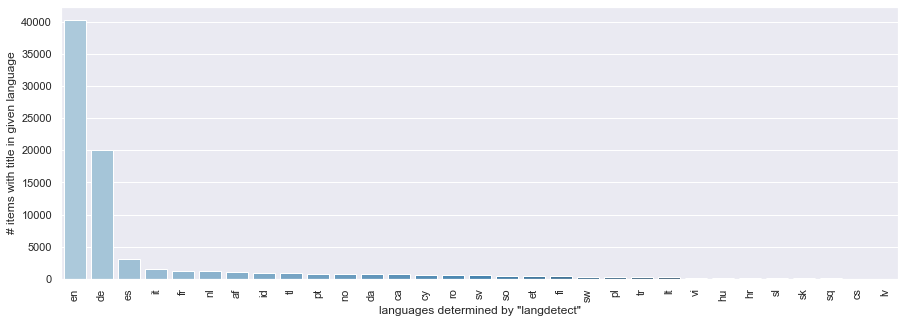

In [79]:
# inspect items w/o language specification -> only numeric !
print(f'cnt of items without language flag: {items_df["title_ld"].isnull().sum()}')
display(items_df[items_df["title_ld"].isnull()].head(10))

# inspect results
ld_vc = pd.DataFrame(items_df['title_ld'].value_counts().reset_index())
display(ld_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_ld', ax=ax, data=ld_vc, palette=palette_blue).set(
    xlabel='languages determined by "langdetect"', 
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### guess_language (=title_gl)

- Can detect very short samples

In [80]:
from guess_language import guess_language

In [81]:
print(guess_language(str_en))
print(guess_language(str_de))

en
de


In [82]:
if recompute_lg_flg:

    # get start time for performance evaluation
    start_time_gl = time.time() 

    # detect langauge of titles 
    items_df['title_gl'] = items_df['title'].apply(lambda x: guess_language(x) if not x.isnumeric() else None)

    # set 'UNKNOWN' to None
    items_df.loc[items_df['title_gl']=='UNKNOWN','title_gl'] = None

    # compute execution time
    end_time_gl = time.time()
    print(f'exection time guess_language: {end_time_gl - start_time_gl} seconds')

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
index,en,de,es,af,fr,it,da,pt,ca,nb,...,hr,so,tr,sw,ss,zu,xh,ts,nr,az
title_gl,20861,10632,2254,1351,1165,1160,1094,895,728,696,...,41,40,39,35,31,23,14,13,7,7


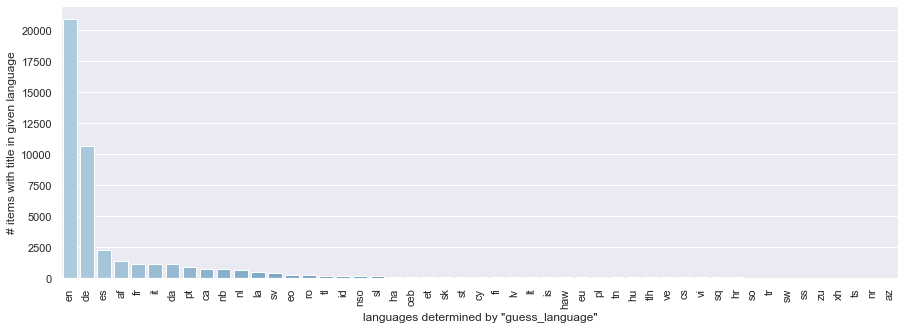

In [83]:
# inspect results
gl_vc = pd.DataFrame(items_df['title_gl'].value_counts().reset_index())
display(gl_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_gl', ax=ax, data=gl_vc, palette=palette_blue).set(
    xlabel='languages determined by "guess_language"', 
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### textblob
Requires NLTK package, uses Google -> API blocked with "HTTP Error 429: Too Many Requests"

##### spacy
- [spacy doku](https://spacy.io/universe/project/spacy-langdetect): did not get it working

##### langid (=title_lg)

In [84]:
import langid

In [85]:
langid.classify(str_en)
langid.classify(str_de)

('de', -96.90802240371704)

In [86]:
if recompute_lg_flg:

    # get start time for performance evaluation
    start_time_lg = time.time() 

    # option 1: pre-calculate list of languages
    title_lg = []

    for title in items_df['title']:
        title_lg.append(langid.classify(title))
        print(f'{title}: {langid.classify(title)}')

    # compute execution time
    end_time_lg = time.time()
    print(f'exection time langid: {end_time_lg - start_time_lg} seconds')

    # add col to df
    items_df['title_lg'] = [t[0] for t in title_lg]

    # option 2: use apply
    # items_df['title_lg'] = items_df['title'].apply(lambda x: TextBlob(x).detect_language() if not x.isnumeric() or  else None)

cnt of items without language flag: 0


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
index,en,de,es,it,fr,nl,da,pt,sv,pl,...,az,ht,zu,se,qu,ja,jv,fo,el,bs
title_lg,47439,18415,3898,1473,1378,610,528,515,494,347,...,7,6,5,5,4,2,2,2,1,1


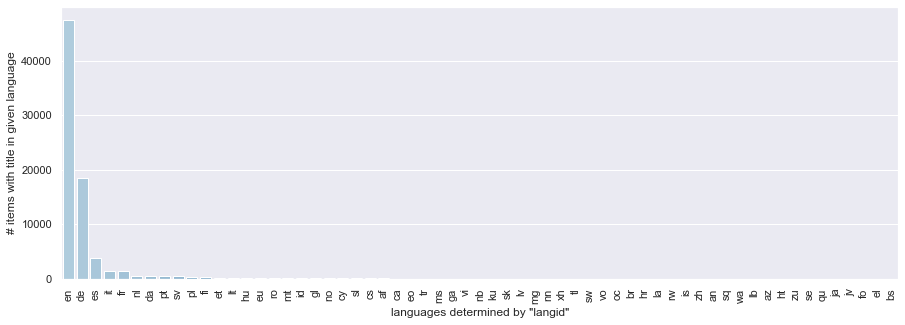

In [87]:
# inspect items w/o language specification -> only numeric !
print(f'cnt of items without language flag: {items_df["title_lg"].isnull().sum()}')
#display(items_df[items_df["title_lg"].isnull()].head(10))

# inspect results
lg_vc = pd.DataFrame(items_df['title_lg'].value_counts().reset_index())
display(lg_vc.transpose())

# show barplot with # items with title in given language
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='index', y='title_lg', ax=ax, data=lg_vc, palette=palette_blue).set(
    xlabel='languages determined by "langid"', 
    ylabel='# items with title in given language'
)
plt.xticks(rotation=90)
plt.show()

##### fasttext
- official Python binding module by Facebook
- problems with installation on windows

### module performance evaluation

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
index,en,de,es,it,fr,nl,af,id,tl,pt,...,wa,lb,ht,se,qu,ja,jv,fo,el,bs
title_ld,40241.0,19974.0,3098.0,1523.0,1262.0,1148.0,1111.0,891.0,838.0,807.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title_gl,20861.0,10632.0,2254.0,1160.0,1165.0,654.0,1351.0,168.0,184.0,895.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title_lg,47439.0,18415.0,3898.0,1473.0,1378.0,610.0,74.0,149.0,21.0,515.0,...,8.0,8.0,6.0,5.0,4.0,2.0,2.0,2.0,1.0,1.0


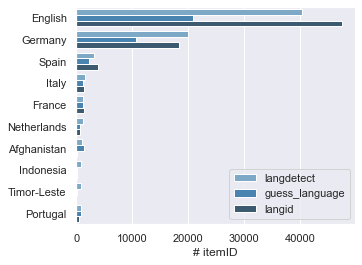

In [155]:
# compare execution time and items w/o flag
if recompute_lg_flg:
    lan_detector_eval_df = pd.DataFrame({'execution time [s]': [eval('end_time_'+det.split("_")[1]) - eval('start_time_'+det.split("_")[1]) for det in ['title_ld','title_gl','title_lg']],
                                        '#items w/o language flg':[items_df[det].isnull().sum() for det in ['title_ld','title_gl','title_lg']]},
                                       index=[det for det in lan_detector.values()])
    display(lan_detector_eval_df)

# merge results dfs
ld_gl_vc = ld_vc.merge(gl_vc, left_on='index', right_on='index', how='outer')
ld_gl_lg_vc = ld_gl_vc.merge(lg_vc, left_on='index', right_on='index', how='outer')
display(ld_gl_lg_vc.transpose())
ld_gl_lg_vc = ld_gl_lg_vc.head(10)

# rename columns
ld_gl_lg_vc.columns = ['index', 'langdetect','guess_language','langid']

# add language name
ld_gl_lg_vc['language_name'] = ld_gl_lg_vc['index'].apply(lambda l: pycountry.countries.get(alpha_2=l).name if l != 'en' else 'English')

# transform model cols into identifier column for plotting
ld_gl_lg_vc = pd.melt(ld_gl_lg_vc, id_vars=["index", "language_name"], 
                  var_name="flag_m", value_name="idCnt")
#display(ld_gl_lg_vc)

# Draw a nested barplot by language detector
sns.set_theme()
fig, ax = plt.subplots(figsize=(5,4))
g = sns.barplot(y="language_name", x="idCnt", hue="flag_m", data=ld_gl_lg_vc, palette=palette_blue, orient='h')
g.set(xlabel="# itemID", ylabel = "")
g.legend(loc='lower right')
plt.show()

### [DEV] Topic Similarity
__TODO: add scraping results of Estelle__

## Export of final pre-processed df

In [ ]:
# print final df to .csv
#items_df.to_csv(items_path_pp)